In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
from utils import QUBO, get_final_ryd_Hamiltonian, get_next_nearest_neighbors, show_coords
import numpy as np
import matplotlib.pyplot as plt

# For 2x2 cells with 8 atoms

We scan J1 from -0.01 to -0.1, and found that 
1. At certain positions (19/100), the Rydberg system cannot find the correct answer for the QUBO problem
2. For J1 < -0.03235, the only solution is all variables take value '1', and Rydberg system can find the correct answer with correct multiplicity
3. For J1 > -0.0211, the Rydberg system can find all the two solutions correctly.
4. For -0.0314 < J1 < -0.0211, the Rydberg system can't find any solutions


In [3]:
J2 = 0.01989
J3 = 0.00617

In [4]:
config = '10011001'
config.count('1')

4

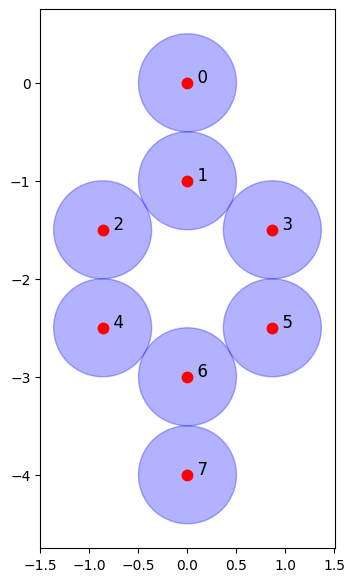

In [7]:
coords = [[0, 0], 
          [0, -1],
          [-np.sqrt(3)/2, -3/2],
          [np.sqrt(3)/2, -3/2],
          [-np.sqrt(3)/2, -5/2],
          [np.sqrt(3)/2, -5/2],
          [0, -3],
          [0, -4],
         ]
show_coords(coords)

In [4]:

neighbors = [
    (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 6), (6, 7)
]

J1range = [-1/i for i in np.linspace(10, 1e2, 100)]

for J1 in J1range:
    
    _, _, _, configs_1, _ = get_final_ryd_Hamiltonian(coords, J1=J1, J2=J2)

    _, _, _, configs_2 = QUBO(neighbors, J1=J1, J2=J2, J3=J3)

    configs_3 = [config for config in configs_1 if config in configs_2]
    print(f"len(configs_1), len(configs_2), len(configs_3) = {len(configs_1)}, {len(configs_2)}, {len(configs_3)}, J1={J1}")

len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.1
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.09166666666666667
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.08461538461538462
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.07857142857142857
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.07333333333333333
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 0, J1=-0.06875
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 0, J1=-0.06470588235294118
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.06111111111111111
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05789473684210526
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05500000000000001
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05238095238095238
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J

# Comparison of spectrum for J1 = -0.1, -0.061111, -0.025, -0.015068, -0.01

In [84]:
def get_energy_contribution_qubo(neighbors, config, J1=0.080403, J2=0.019894, J3=0.0):
    next_nearest_neighbors = get_next_nearest_neighbors(neighbors)
    num_atoms = max(list(sum(neighbors, ()))) + 1
    
    # contribution of the linear term
    E_1 = config.count('1') * J1
    
    # contribution of the nearest neighbor term
    E_2 = 0
    for (i,j) in neighbors:
        if i < j and config[i] == '1' and config[j] == '1':
            E_2 += J2
    
    # contribution of the next nearest neighbor term
    E_3 = 0
    for i in range(num_atoms):
        for j in next_nearest_neighbors[i]:
            if i < j and config[i] == '1' and config[j] == '1': 
                E_3 += J3
    
    return E_1, E_2, E_3


def get_energy_contribution_rydberg(
    neighbors,
    coords, 
    config,
    detuning = 125000000.0,
    J1=0.080403, 
    J2=0.019894,
    C6 = 5.42e-24,
    threshold_factor = 1/18        
):
    
    if J1 == 0:
        detuning = 0
#         R = 8e-6
    elif J1 < 0:
        detuning = abs(detuning)
    else:
        detuning = -abs(detuning)
        
    if J2 * threshold_factor < abs(J1):
        R = (C6/detuning * -J1/J2)**(1/6)
    else:
        warnings.warn("J1 is too small")
        R1 = (C6 / 27 / abs(detuning))**(1/6)
        R2 = (C6 / abs(detuning))**(1/6)        
        R = (R1+R2)/2 
        
    num_atoms = max(list(sum(neighbors, ()))) + 1
    next_nearest_neighbors = get_next_nearest_neighbors(neighbors)
    
    # contribution of the linear term
    E_1 = config.count('1') * (-detuning)
    
    # contribution of the nearest neighbor term
    E_2 = 0
    for (i,j) in neighbors:
        if i < j and config[i] == '1' and config[j] == '1':
            E_2 += C6/(R**6)
    
    # contribution of the next nearest neighbor term
    E_3 = 0
    for i in range(num_atoms):
        for j in next_nearest_neighbors[i]:
            if i < j and config[i] == '1' and config[j] == '1': 
                E_3 += C6/((np.sqrt(3) * R)**6)
    
    E_1, E_2, E_3 = E_1/1e6, E_2/1e6, E_3/1e6
    
    return E_1, E_2, E_3


In [8]:
def compare_spectrum(ryd_H, qubo_H, num_plots=1):
    
    if num_plots==2:
        
        fig, axes = plt.subplots(1, 2, figsize = (12, 6))

        axes[0].plot(ryd_H, '.')
        axes[1].plot(qubo_H, '.')
        axes[0].set_title(f"Spectrum of Rydberg Ham for J1={J1}")
        axes[1].set_title(f"Spectrum of QUBO for J1={J1}")
        axes[0].set_ylabel("energy")
        axes[0].set_xlabel("states")
        axes[1].set_xlabel("states")
        axes[0].grid()
        axes[1].grid()
        plt.show()
        
    elif num_plots==1:
        plt.figure(figsize=(12,6))
        ryd_H_scaled = ryd_H / (max(ryd_H) - min(ryd_H)) * (max(qubo_H) - min(qubo_H))
        plt.plot(ryd_H_scaled, '.', label="Rydberg Ham")
        plt.plot(qubo_H, '.', label="QUBO")
        plt.title(f"Spectrum for J1={J1}")
        plt.xlabel("states")
        plt.xlabel("energy")
        plt.legend()
        plt.grid()
        plt.show()
        
def compare_energy_fraction(ryd_H, qubo_H, J1, J2, J3, neighbors, coords, detuning=125000000.0, num_plots=2):
    
    num_atoms = int(np.log2(len(ryd_H)))
        
    ryd_energy_fraction = []
    for i in range(len(ryd_H)):
        config = f'{i:0{num_atoms}b}'
        ryd_E_1, ryd_E_2, ryd_E_3 = get_energy_contribution_rydberg(neighbors, coords, config, detuning, J1=J1, J2=J2)
        temp = np.array([ryd_E_1, ryd_E_2, ryd_E_3])
#         ryd_energy_fraction.append(temp/sum(temp))
        ryd_energy_fraction.append(temp)
        
    qubo_energy_fraction = []
    for i in range(len(qubo_H)):
        config = f'{i:0{num_atoms}b}'
        qubo_E_1, qubo_E_2, qubo_E_3 = get_energy_contribution_qubo(neighbors, config, J1=J1, J2=J2, J3=J3)
        temp = np.array([qubo_E_1, qubo_E_2, qubo_E_3])
#         qubo_energy_fraction.append(temp/sum(temp))
        qubo_energy_fraction.append(temp)
                
        
    
    if num_plots==2:
        
        fig, axes = plt.subplots(1, 2, figsize = (12, 6))
        colors=['r', 'g', 'b']
        for j in range(3):
            axes[0].plot([item[j] for item in ryd_energy_fraction], '.', c=colors[j], label=f"E_{j+1}")
        
        axes[0].set_title(f"Energy fraction for Rydberg Ham for J1={J1}")
        axes[0].set_ylabel("energy")
        axes[0].set_xlabel("states")
        axes[0].legend()
        axes[0].grid()
        
        for j in range(3):
            axes[1].plot([item[j] for item in qubo_energy_fraction], '.', c=colors[j], label=f"E_{j+1}")
        
        axes[1].set_title(f"Energy fraction for QUBO for J1={J1}")
        axes[1].set_ylabel("energy")
        axes[1].set_xlabel("states")
        axes[1].legend()
        axes[1].grid()
        
        plt.show()
        
    elif num_plots==1:
        pass
        
        

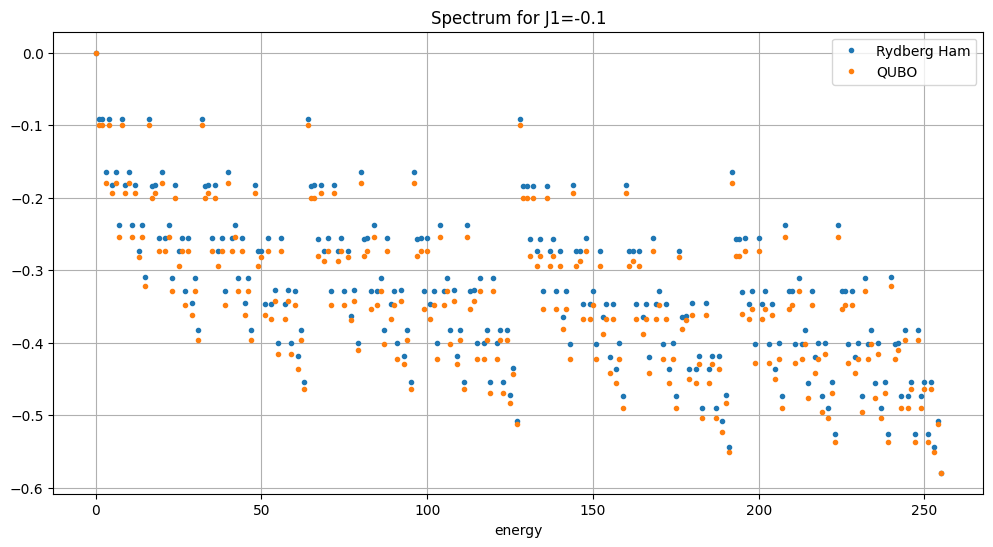

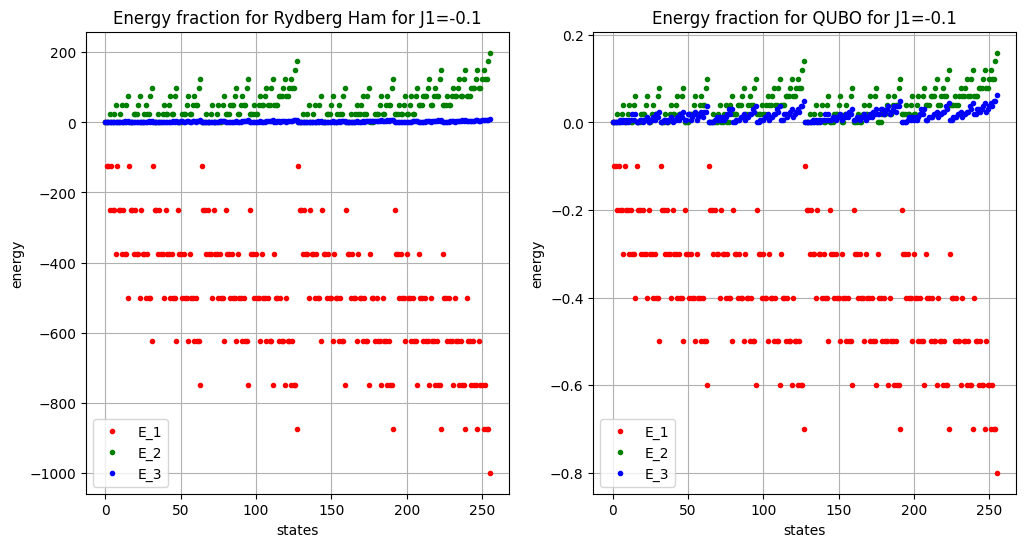

In [92]:
J1 = -0.1
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1, J2=J2)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1, J2=J2, J3=J3)

compare_spectrum(ryd_H, qubo_H, num_plots=1)
compare_energy_fraction(ryd_H, qubo_H, J1, J2, J3, neighbors, coords)

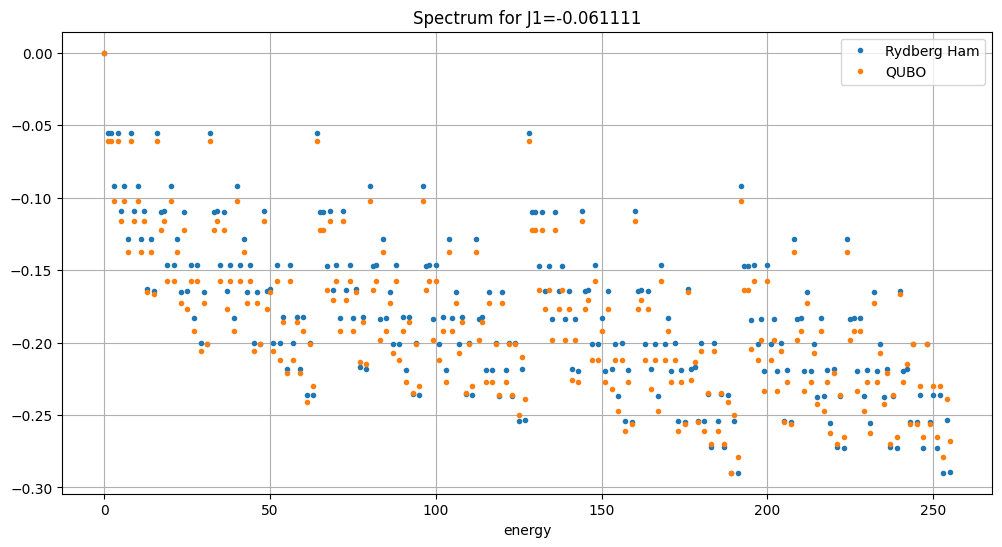

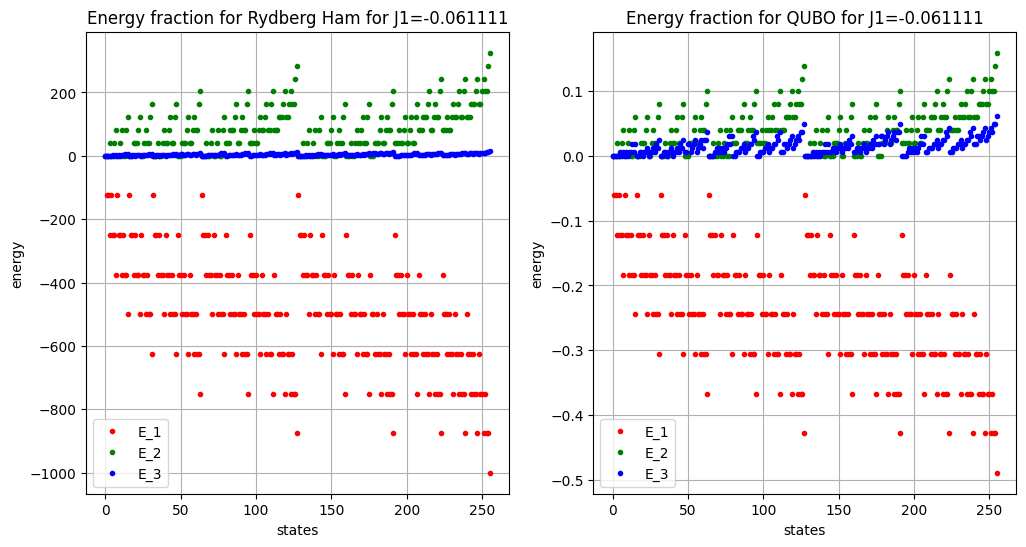

In [93]:
J1 = -0.061111
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1, J2=J2)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1, J2=J2, J3=J3)

compare_spectrum(ryd_H, qubo_H, num_plots=1)
compare_energy_fraction(ryd_H, qubo_H, J1, J2, J3, neighbors, coords)

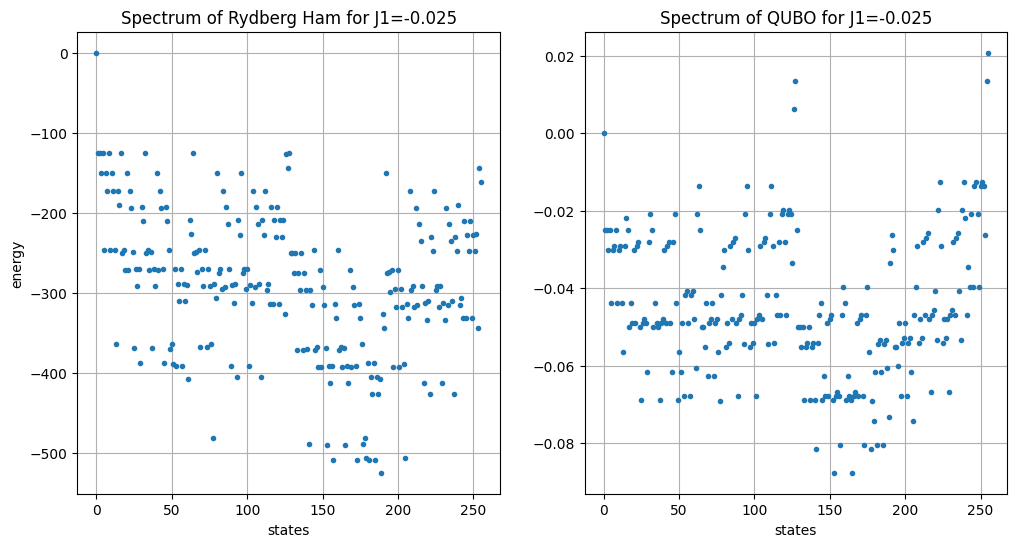

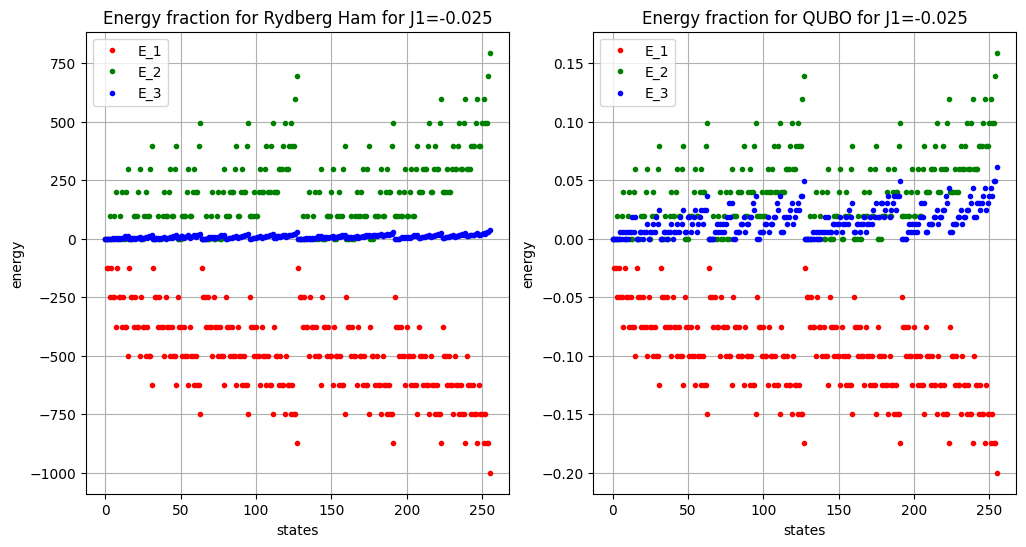

In [94]:
J1 = -0.025
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1, J2=J2)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1, J2=J2, J3=J3)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_energy_fraction(ryd_H, qubo_H, J1, J2, J3, neighbors, coords)

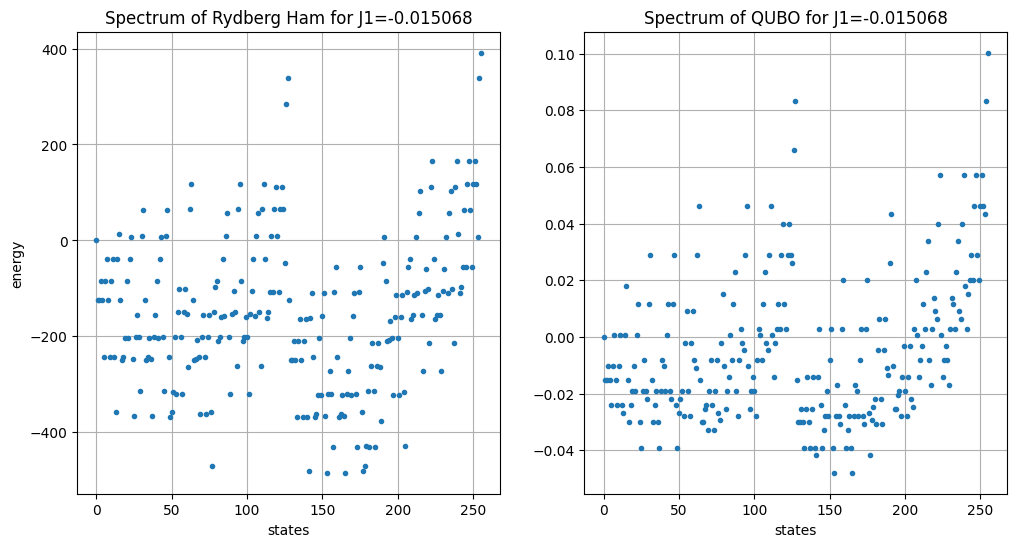

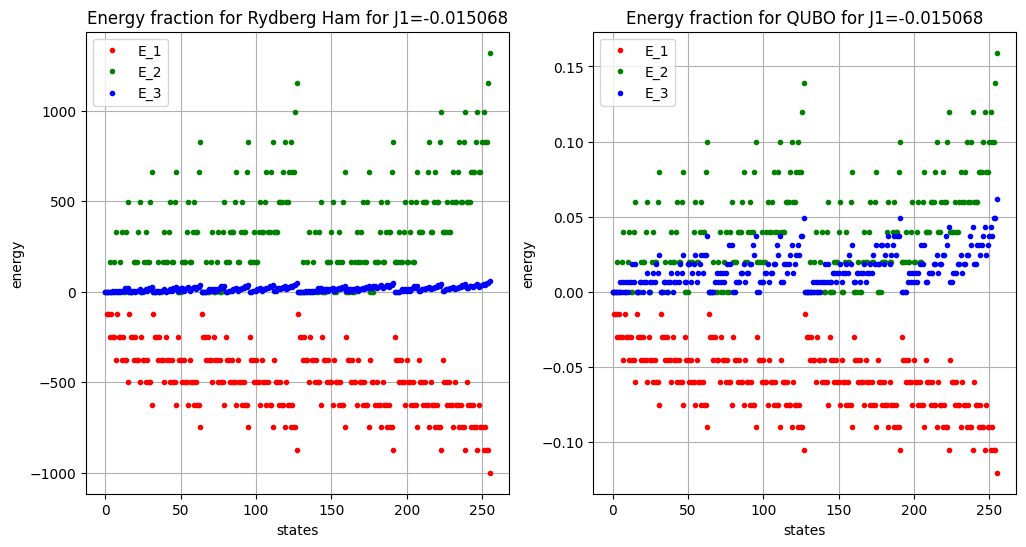

In [95]:
J1 = -0.015068
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1, J2=J2)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1, J2=J2, J3=J3)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_energy_fraction(ryd_H, qubo_H, J1, J2, J3, neighbors, coords)

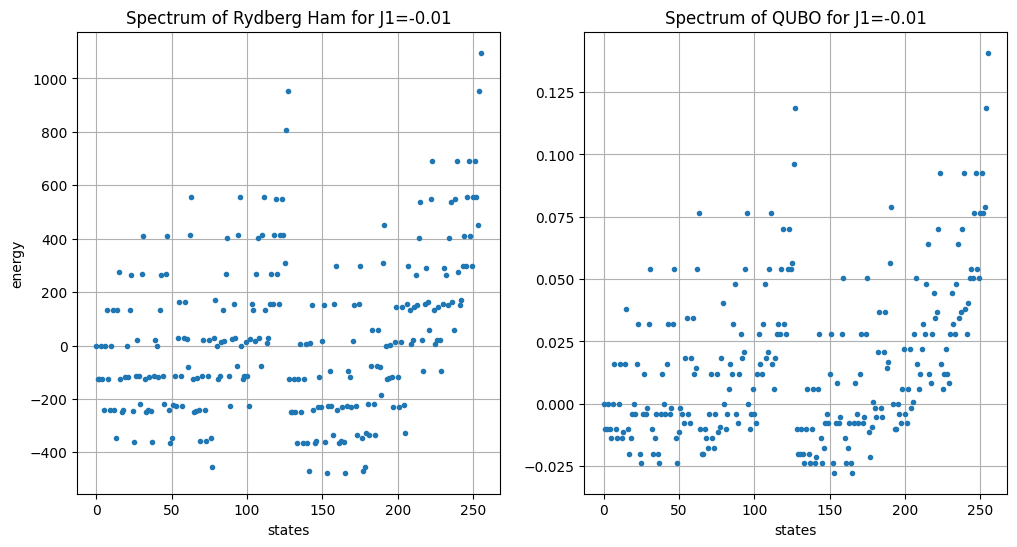

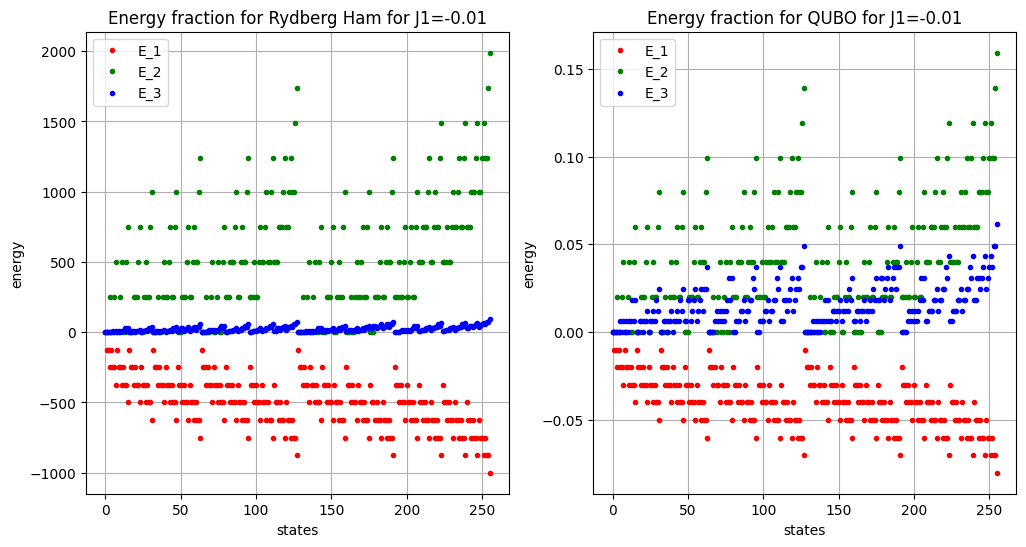

In [96]:
J1 = -0.01
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1, J2=J2)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1, J2=J2, J3=J3)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_energy_fraction(ryd_H, qubo_H, J1, J2, J3, neighbors, coords)